In [1]:
import os
import sys
from Bio import SeqIO
from Bio.SeqFeature import FeatureLocation
from Bio import AlignIO
import re
from matplotlib import pyplot as plt
import matplotlib as mpl
import baltic as bt
from glob import glob

alignment, reference_file = '../../data/subsampled_alignments/denv1.fasta','../../data/reference_seqs/dengue_virus_1_outgroup.gb'
alignmentobject = AlignIO.read(open(alignment, 'r'), 'fasta')
protein_list = ['C', 'M', 'E', 'NS1', 'NS2A', 'NS2B', 'NS3', 'NS4A', '2K', 'NS4B', 'NS5']

In [4]:
def load_reference(reference_file):
    reference_seq = SeqIO.read(reference_file, 'genbank')
    seen = []
    proteins = {}
    for f in reference_seq.features:
        if 'product' in f.qualifiers:
            gene = f.qualifiers['product'][0].split()[-1]
            if gene not in seen and gene in protein_list:
                proteins[gene] = FeatureLocation(start=f.location.start, end=f.location.end, strand=1)
                seen.append(gene)
    return sorted(proteins.items(), key=lambda i: protein_list.index(gene)), reference_seq

def convert_coordinate(refseq, compareseq, coordinate):
    coordinate = coordinate - 1 # Adjust for python coordinates
    #check to make sure we have at least 100bp of downstream sequence, no more than 40bp of which are gaps, to match on
    assert len(refseq[coordinate:]) >= 100 and refseq[coordinate:coordinate+100].count('-')<40, 'ERROR: Not enough downstream context available for '+str(coordinate+1)
    #check to make sure the given coordinate doesn't correspond to a gap in the reference sequence
    assert refseq[coordinate] != '-', 'ERROR! Coordinate '+str(coordinate+1)+' is a gap in the reference sequence.'

    reference = refseq[coordinate:coordinate+100].replace('-', '')
    refpattern = '-*'.join(list(reference)) # Match in new sequence while ignoring of gaps
    matchlist = re.findall(refpattern, compareseq) #check to make sure we get one and only one match
    assert len(matchlist) == 1, 'ERROR: found %d matches for coordinate %d'%(len(matchlist), coordinate+1)
    return re.search(refpattern, compareseq).start()+1 #return the starting and converted (genomic) coordinates

def split_alignment(alignment_file, proteins):
    align = AlignIO.read(open(alignment_file, 'r'), 'fasta')
    ofile_stem = alignment_file.split('/')[-1].split('.')[0]
    ofile_list = []
    for protein, (start, end) in proteins:
        ofile_name = ofile_stem+'_%s.phyx'%(protein)
        ofile_list.append(ofile_name)
        start, end = start - 1, end - 1 # adjust for pythonic coordinates
        align_segment = align[:, start:end+1] #[allrows, startcolumn:endcolumn] endcolumn += 1 for inclusive slicing
        filtered_align_segment = AlignIO.MultipleSeqAlignment([])
        for seq in align_segment:
            if float(str(seq.seq).count('-')) / float(len(str(seq.seq))) <= 0.70:
                filtered_align_segment.append(seq)
        AlignIO.write(filtered_align_segment, ofile_name, 'phylip-relaxed')
    return ofile_list

def run_raxml(alignment_list):
    for a in alignment_list:
        protein = a.split('_')[-1].split('.')[0]
        os.system('raxml -f d -T 2 -j -s %s -n topology_%s -c 25 -m GTRCAT -p 344312987'%(a, protein))
        for i in ['rm RAxML_info*', 'rm RAxML_checkpoint*', 'rm RAxML_parsimonyTree*', 'rm RAxML_result*', 'rm RAxML_log*', 'rm *.reduced']:
            os.system(i)

####### Run #########################
proteins, reference_seq = load_reference(reference_file)
reference_acc, reference_seq = reference_seq.id.split('.')[0], str(reference_seq.seq)
compare_seq = None
for i in SeqIO.parse(alignment, 'fasta'):
    if i.description.split('|')[1].split('.')[0] == reference_acc:
        compare_seq = str(i.seq)
assert compare_seq != None

converted_proteins = []
for gene, loc in proteins: ### extract integer start and end from location object
    start = convert_coordinate(reference_seq, compare_seq, int(loc.start))
    end = convert_coordinate(reference_seq, compare_seq, int(loc.end))
    converted_proteins.append((gene, (start, end)))
proteins = converted_proteins

# alignments = split_alignment(alignment, proteins)
# run_raxml(alignments)


In [2]:
def euclidean((x1,y1),(x2,y2)):
    return ((float(x2)-float(x1))**2+(float(y1)-float(y2))**2)**0.5

def sum_tip_distances(tree1,tree2):
    tree1_tips = { k.numName: k for k in tree1.Objects if k.branchType=='leaf' }
    tree2_tips = { k.numName: k for k in tree2.Objects if k.branchType=='leaf' }
    shared_tips = set(tree1_tips.keys()).intersection(set(tree2_tips.keys()))
    total_dist = 0.0

    for t in shared_tips:
        total_dist += euclidean( (tree1_tips[t].x, tree1_tips[t].y), (tree2_tips[t].x, tree2_tips[t].y) )

    return total_dist

def untangle(tree1, tree2):
    current_distance = sum_tip_distances(tree1, tree2)

    for n in sorted(tree2.nodes,key=lambda x: -x.height):
        if n.parent=='Root':
            continue
        n.rotate()
        tree2.drawTree()
        new_distance = sum_tip_distances(tree1, tree2)
        if new_distance <= current_distance:
            current_distance = new_distance
            continue
        else:
            n.rotate()
            tree2.drawTree()

treefiles = sorted(glob('*bestTree*'), key=lambda i: protein_list.index(i.split('_')[-1]))
trees = {}
for i, t in enumerate(treefiles):
    treestring, treeobject = open(t, 'r').readline().strip(), bt.tree()
    bt.make_tree(treestring, treeobject)
    treeobject.treeStats() ## initial traversal, checks for stats
    treeobject.sortBranches() ## traverses tree, sorts branches, draws tree
    trees[i] = treeobject
print trees
    
for i in range(1,len(treefiles)):
    print i
    untangle(trees[i-1], trees[i])


Tree height: 0.162320
Tree length: 1.117768

Tree is strictly bifurcating = False

Tree is multitype = False

Tree has annotations = False

Numbers of objects in tree: 378 (188 nodes and 190 leaves)


Tree height: 0.138876
Tree length: 1.311712

Tree is strictly bifurcating = False

Tree is multitype = False

Tree has annotations = False

Numbers of objects in tree: 378 (188 nodes and 190 leaves)


Tree height: 0.144353
Tree length: 1.455384

Tree is strictly bifurcating = False

Tree is multitype = False

Tree has annotations = False

Numbers of objects in tree: 380 (189 nodes and 191 leaves)


Tree height: 0.165919
Tree length: 1.325225

Tree is strictly bifurcating = False

Tree is multitype = False

Tree has annotations = False

Numbers of objects in tree: 380 (189 nodes and 191 leaves)


Tree height: 0.193253
Tree length: 1.555843

Tree is strictly bifurcating = False

Tree is multitype = False

Tree has annotations = False

Numbers of objects in tree: 380 (189 nodes and 191 leav

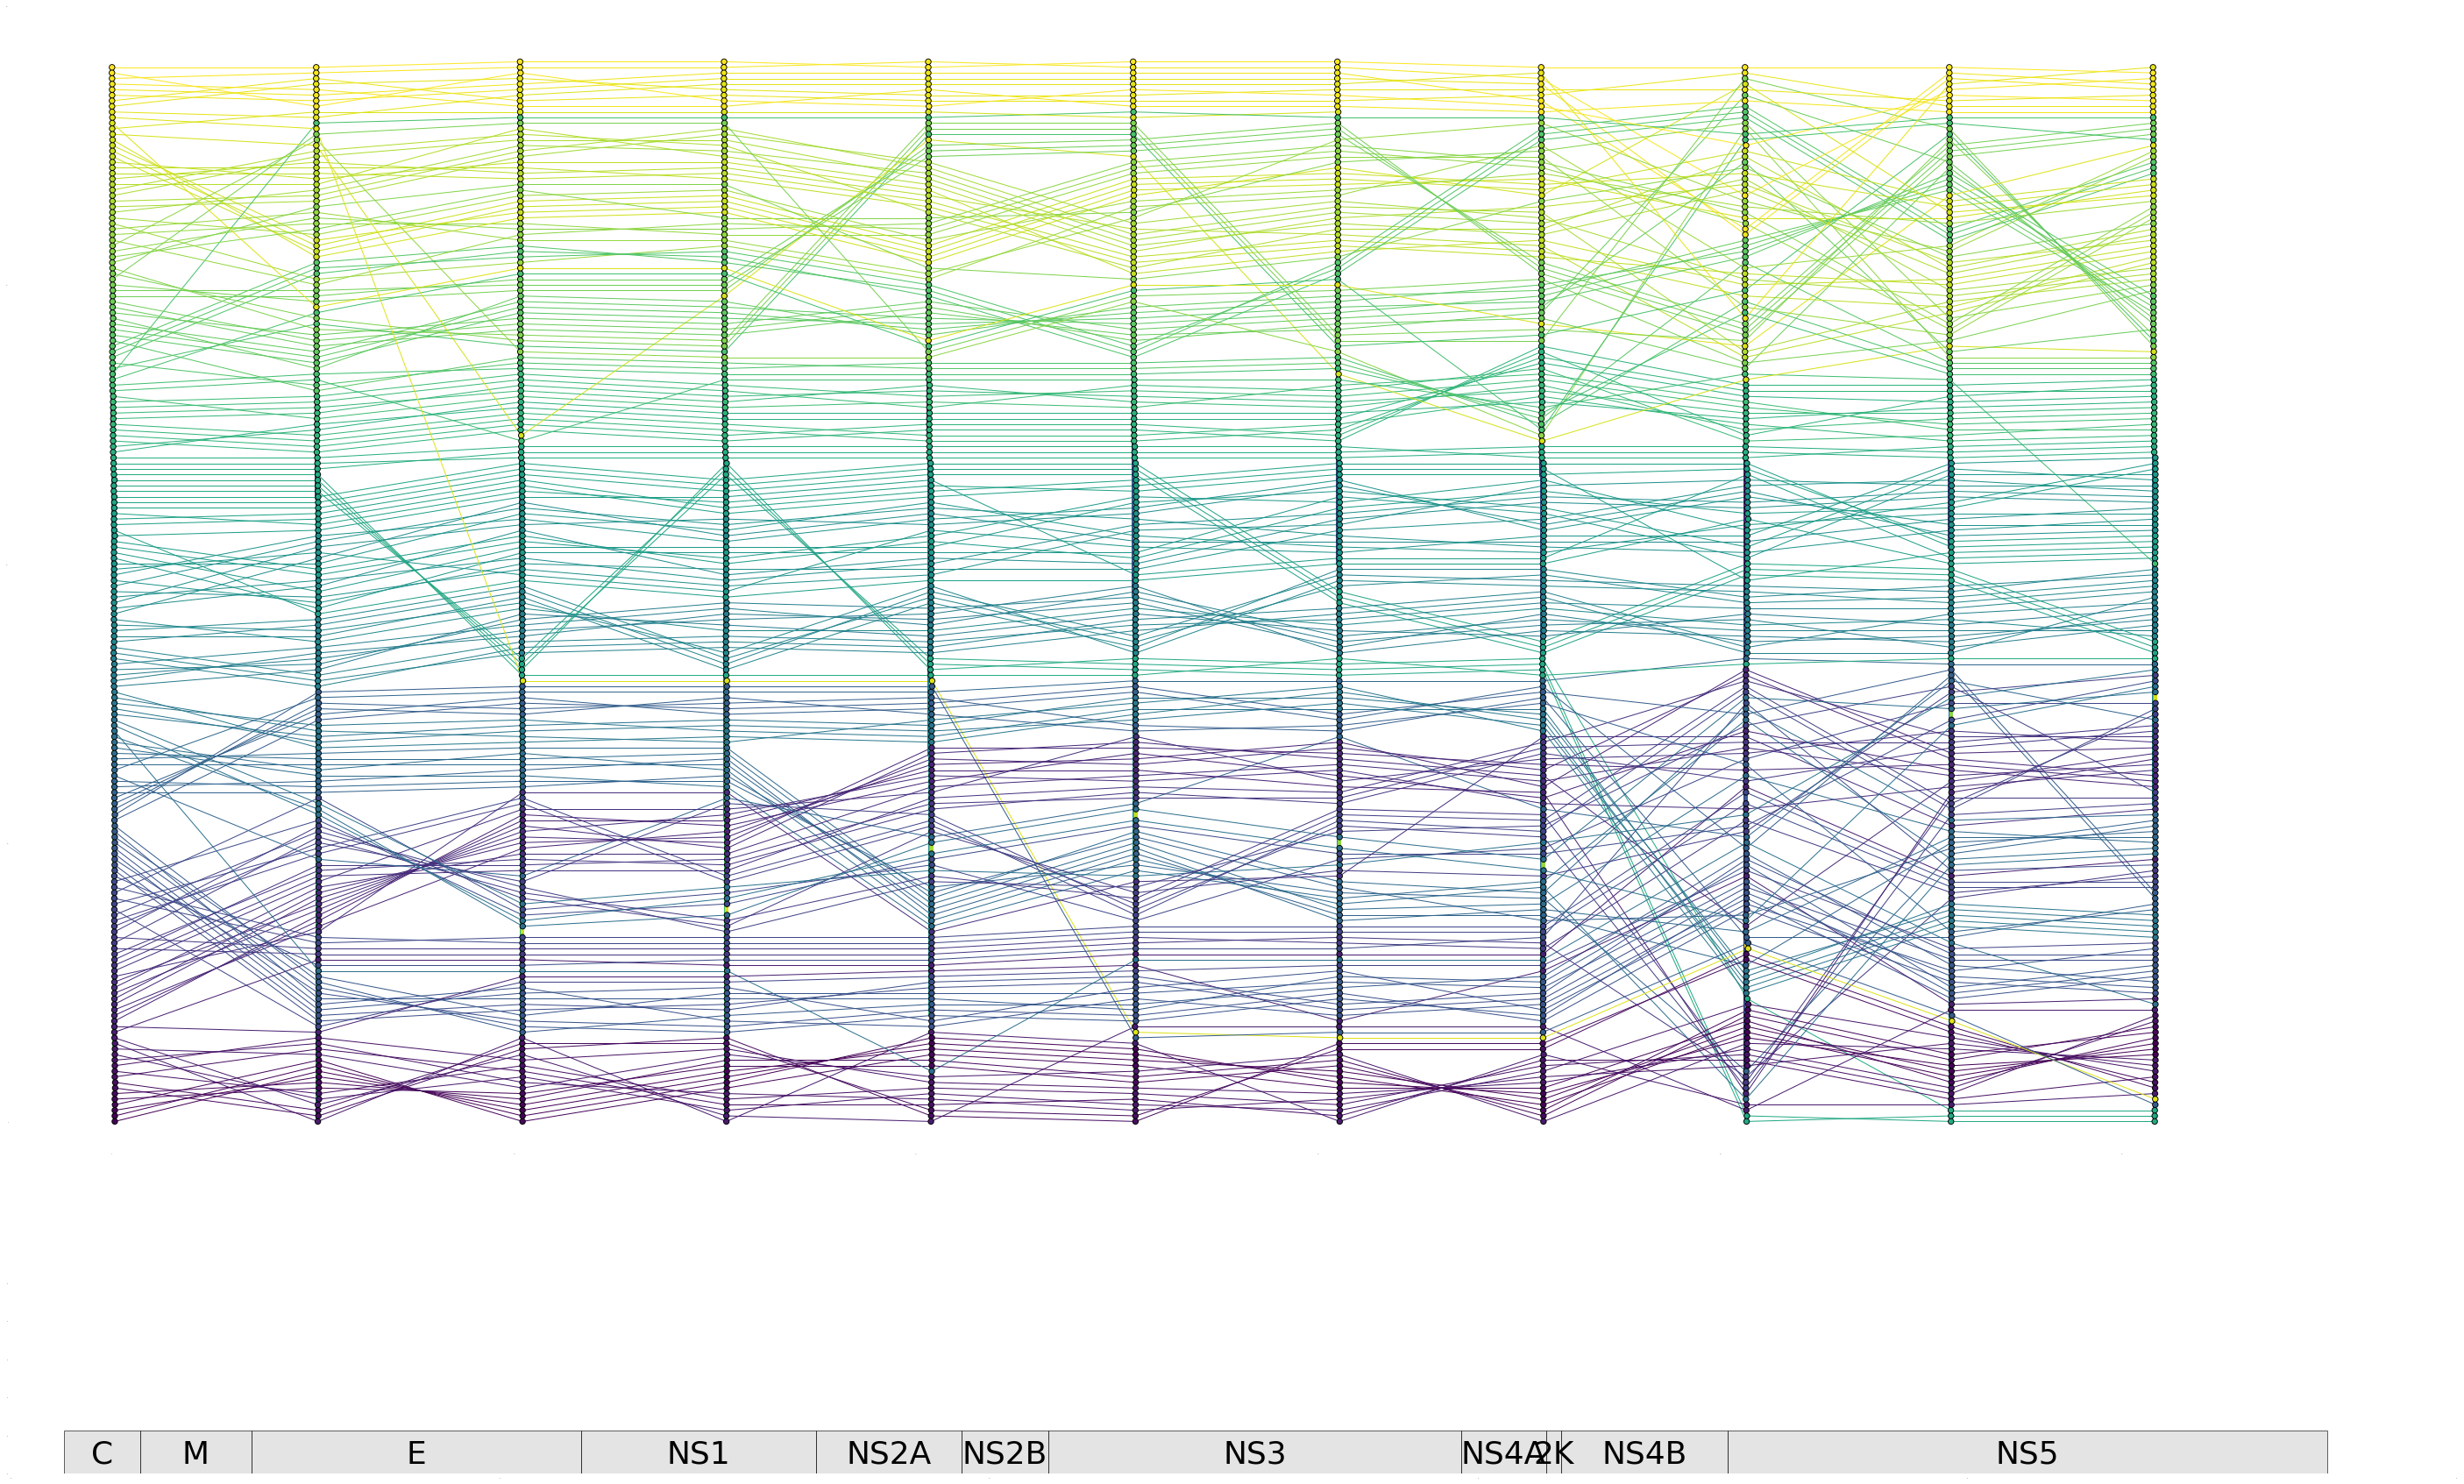

In [28]:
######## Plotting utilities #########

################
## Plot Genome Map
################
%matplotlib inline
fig, (ax, genome) = plt.subplots(2, figsize=(50,30), gridspec_kw = {'height_ratios':[6, 1]}) #sharex=True)
genomeL=float(len(str(alignmentobject[0].seq)))

def rescale(x):
    return (float(x)/genomeL)

for gene, i in proteins:
    length = rescale(i[1]-i[0])
    genome.text(rescale(i[0])+0.5*length, 0.1,'%s'%(gene),va='center',ha='center',size=36,zorder=11)

    c = 'lightgray'
    genome.arrow(rescale(i[0]), 0.1, length, 0.0, alpha=0.6,head_width=0.15, width=0.25,head_length=0.0,length_includes_head=True,facecolor=c)

genome.set_ylim(0,1) ## set y limits
genome.set_xlim(0, 1)

genome.spines['top'].set_visible(False)
genome.spines['right'].set_visible(False)
genome.spines['left'].set_visible(False)
genome.spines['bottom'].set_visible(False)

genome.tick_params(axis='x',labelsize=0,size=0)
genome.tick_params(axis='y',labelsize=0,size=0)

######################
## Plot Trees
#####################

tree_names=protein_list ## define order in which dict will be accessed
tip_positions={x:{} for x in tree_names} ## remember the position of each tip in each tree

traitName='None' ## choose a trait to colour branches by
cmap=mpl.cm.viridis
cumulative_displace=0 ## this tracks the "current" x position, so trees are plotted one after another

branchWidth=4 ## increase branch width, since trees will be smaller


for t, tr in enumerate(tree_names): ## iterate over trees
    cur_tree=trees[t] ## fetch tree object
    for k in cur_tree.Objects: ## iterate over branches
        if isinstance(k,bt.leaf): ## only interested in leaves
            tip_positions[tr][k.numName]=(k.height,k.y) ## remember tree, tip's position

for t,tr in enumerate(tree_names): ## iterate over trees
    cur_tree=trees[t] ## fetch tree object
    
    for k in cur_tree.Objects: ## iterate over branches
#         x=k.x ## or from x position determined earlier
        x=k.height ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

#         xp=k.parent.x ## get x position of current object's parent
        xp=k.parent.height ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
    
        x+=cumulative_displace ## adjust branch position by displacement, which depends on the position of tree in the overall plot
        xp+=cumulative_displace ## same for branch's parent
    #     c='indianred' ## colour can be fixed
        c=cmap(k.height/cur_tree.treeHeight) ## or be a function of something else
    #     c=[cmap(k.traits['posterior']) if k.traits.has_key('posterior') else cmap(1.0)][0]
#         if k.traits.has_key(traitName):
#             c=['indianred' if k.traits[traitName]=='V' else 'steelblue'][0] ## can be discrete too
#         else:
#             c='k'
        if isinstance(k,bt.leaf): ## if leaf...
            #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name

            s=30 ## tip size can be fixed
            try:
                pos_in_first_tree=tip_positions[tree_names[0]][k.numName][1] ## fetch y coordinate of same tip in the first tree
                frac_pos=pos_in_first_tree/float(len(cur_tree.Objects))*2.0 ## normalize coordinate to be within interval [0.0,1.0]

                ax.scatter(x,y,s=s,facecolor=cmap(frac_pos),edgecolor='none',zorder=11) ## plot circle for every tip
                ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

                if t!=len(tree_names)-1: ## as long as we're not at the last tree - connect tips with coloured lines
                    next_x,next_y=tip_positions[tree_names[t+1]][k.numName] ## fetch coordinates of same tip in next tree
                    next_x+=cumulative_displace+cur_tree.treeHeight+10 ## adjust x coordinate by current displacement and future displacement

                    ax.plot([x,next_x],[y,next_y],lw=1,ls='-',color=cmap(frac_pos),zorder=0) ## connect current tip with same tip in the next tree
            except:
                continue
                    
        elif isinstance(k,bt.node): ## if node...
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) ## plot vertical bar

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9) ## always plot branch
        
    cumulative_displace+=cur_tree.treeHeight+10 ## increment displacement by the height of the tree

ax.set_ylim(-5,len([x for x in cur_tree.Objects if isinstance(x,bt.leaf)])+10) ## set y limits
ax.set_xlim(-5,cumulative_displace+5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=0,size=0)
ax.tick_params(axis='y',labelsize=0,size=0)

plt.show()
